# Task 1: Histogram equalization and counting

In [1]:
import pydicom
import matplotlib.pyplot as plt
import monai
import torch
import os
import numpy as np
from torchvision.transforms import Resize
from torchvision.transforms.functional import InterpolationMode
import time


In [2]:
# load data
DICOM_PATH = '/apps/local/shared/HC701/assessment/assignment_1/task_1'
files = os.listdir(DICOM_PATH)
imgs = []
for file in files:
    xray_img_reader = pydicom.read_file(os.path.join(DICOM_PATH,file))
    imgs.append(xray_img_reader.pixel_array)
NUM_FILE = len(imgs)

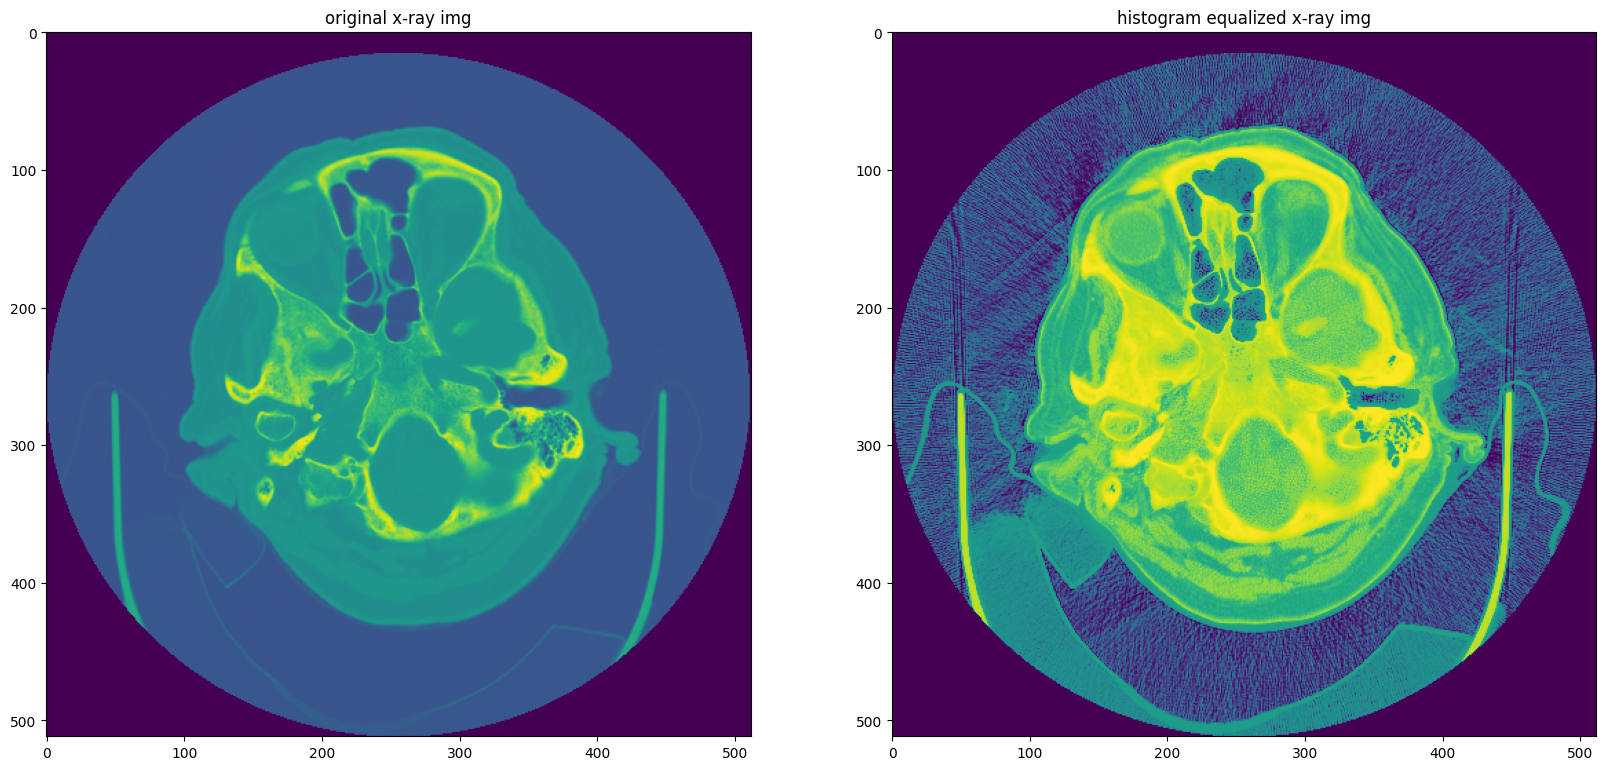

In [7]:
# histogram equalization
def EqualHist(img):
    intensity_max = np.max(img)
    intensity_min = np.min(img)
    n_levels = intensity_max-intensity_min+1
    # convert intensity from [min,max] to [0,max+min]
    img = img - intensity_min
    # compute histogram
    histogram = np.bincount(img.flatten(),minlength=n_levels)
    # Mapping function
    uniform_hist = (n_levels-1) * (np.cumsum(histogram)/(img.size*1.0))
    uniform_hist = uniform_hist.astype(histogram.dtype)
    # set the intensity of the pixel in the raw img to its corresponding new intensity
    equ_img = np.zeros(img.shape,dtype=img.dtype)
    height, width = img.shape
    for i in range(height):
        for j in range(width):
            equ_img[i,j] = uniform_hist[img[i,j]]
    # convert intensity from [0,max+min] to [min,max]
    equ_img += intensity_min
    return equ_img

equ_imgs = []
times = []
for img in imgs:
    t1 = time.time()
    equ_img = EqualHist(img)
    t2 = time.time()
    equ_imgs.append(equ_img)
    times.append(t2-t1)
# show an example
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('original x-ray img')
plt.imshow(imgs[1])
plt.subplot(1,2,2)
plt.title('histogram equalized x-ray img')
plt.imshow(equ_imgs[1])
plt.show()




In [8]:
# normalization to [-1,1]
normal_imgs = []
means = []
for i in range(NUM_FILE):
    img = equ_imgs[i]
    t1 = time.time()
    p = np.min(img)
    q = np.max(img)
    # print(q,p)
    a = 2/(q-p)
    b = (p+q)/(q-p)
    # print(a,b)
    img = a * img - b
    # print(np.max(img),np.min(img))
    t2 = time.time()
    times[i] += t2-t1
    mean = np.mean(img)
    means.append(mean)
    normal_imgs.append(img)
print('normalize image to [-1,1]')
for i in range(len(means)):
    print(f'{i+1} th image mean: {means[i]}')


normalize image to [-1,1]
1 th image mean: 0.011609205560585947
2 th image mean: -0.24109864996428476
3 th image mean: 0.005763633020462551
4 th image mean: -0.21124002870344952
5 th image mean: -0.21246294589409553
6 th image mean: -0.20042441981956033
7 th image mean: -0.2397743340027302
8 th image mean: 0.01551773348761325
9 th image mean: 0.01606872448554407
10 th image mean: 0.01025845882729402
11 th image mean: -0.1801853625058673
12 th image mean: 0.012039630980960524
13 th image mean: 0.013606714962714983
14 th image mean: -0.20840872403541005
15 th image mean: 0.008088385591221344
16 th image mean: 0.060673499240061296
17 th image mean: -0.20247968471416247
18 th image mean: 0.006853912628448771
19 th image mean: 0.0016697714359309706
20 th image mean: -0.23708721837081476


In [9]:
# normalize to [-0.9,0.8]
re_normal_imgs = []
re_means = []
for i in range(NUM_FILE):
    img = normal_imgs[i]
    t1 = time.time()
    img[img>0]  = img[img>0] * 0.8
    img[img<0] = img[img<0] * 0.9
    t2 = time.time()
    times[i] += t2-t1
    mean = np.mean(img)
    re_means.append(mean)
    re_normal_imgs.append(img)
print('normalize image to [-0.9,0.8]')
for i in range(len(re_means)):
    print(f'{i+1} th image mean: {re_means[i]}')


normalize image to [-0.9,0.8]
1 th image mean: -0.014715833235693174
2 th image mean: -0.2358769453959771
3 th image mean: -0.019833891430412053
4 th image mean: -0.2097709643445545
5 th image mean: -0.21084854100544698
6 th image mean: -0.2001665836919589
7 th image mean: -0.2347813982075402
8 th image mean: -0.011180404044158824
9 th image mean: -0.010639039577289911
10 th image mean: -0.015887440014956594
11 th image mean: -0.18208718544904157
12 th image mean: -0.014220156269177888
13 th image mean: -0.012833030050449909
14 th image mean: -0.2075131136553174
15 th image mean: -0.017785003475795067
16 th image mean: 0.029448599016713345
17 th image mean: -0.20220888838865422
18 th image mean: -0.01900803382117465
19 th image mean: -0.023671605234927937
20 th image mean: -0.23249188419501515


In [10]:
# sort and report
sort_means = np.sort(re_means)
print(f'sorted intensity mean :{sort_means}')
print(f'mean time to process images {np.mean(times)}')
print(f'standard variance time to process images {np.std(times)}')


sorted intensity mean :[-0.23587695 -0.2347814  -0.23249188 -0.21084854 -0.20977096 -0.20751311
 -0.20220889 -0.20016658 -0.18208719 -0.02367161 -0.01983389 -0.01900803
 -0.017785   -0.01588744 -0.01471583 -0.01422016 -0.01283303 -0.0111804
 -0.01063904  0.0294486 ]
mean time to process images 0.09338130950927734
standard variance time to process images 0.006708217389770064


In [17]:
# check RAM spec
import psutil

def check_ram_spec():
    # Get the total RAM
    total_ram = psutil.virtual_memory().total
    
    # Get the available RAM
    available_ram = psutil.virtual_memory().available
    
    # Print the results
    print(f"Total RAM: {total_ram/(1024**3)} GB")
    print(f"Available RAM: {available_ram/(1024**3)} GB")
    
# Call the function
check_ram_spec()

Total RAM: 125.57161712646484 GB
Available RAM: 118.15116882324219 GB


# Task 2: 3D image visualization

## Task 2.1: GUI

In [4]:

# load data
MRI_DATA_PATH = "/apps/local/shared/HC701/assessment/assignment_1/task_2/task_2_1"

file_list = os.listdir(MRI_DATA_PATH)
# sort file_list
file_list.sort()
Imgs = []

for file in file_list:
    xray_img_reader = pydicom.read_file(os.path.join(MRI_DATA_PATH,file))
    Imgs.append(xray_img_reader.pixel_array)
Imgs = np.array(Imgs)
Imgs.shape


(180, 528, 528)

In [7]:
import tkinter as tk
import time
from PIL import Image, ImageTk


root = tk.Tk(screenName='localhost:10.0')
root.title("MRI Scan Visualization")
global i
global img
global current_var
i = 0
current_var = "axial"
# Create a small GUI to allow the user to choose one of the three orientation options
var = tk.StringVar(value="axial")
axial = tk.Radiobutton(root, text="Axial", variable=var, value="axial")
coronal = tk.Radiobutton(root, text="Coronal", variable=var, value="coronal")
sagittal = tk.Radiobutton(root, text="Sagittal", variable=var, value="sagittal")
axial.pack()
sagittal.pack()
coronal.pack()
window = tk.Label(root,width=528,height=528)
window.pack()
img = None

def update():
    global i
    global img
    global current_var
    if var.get() != current_var:
        i = 0
        current_var = var.get()
    if var.get() == "axial":
        img = Image.fromarray(Imgs[i,:,:])
        num_slices = Imgs.shape[0]
    elif var.get() == "coronal":
        img = Image.fromarray(Imgs[:,i,:])
        num_slices = Imgs.shape[1]
    elif var.get() == "sagittal":
        img = Image.fromarray(Imgs[:,:,i])
        num_slices = Imgs.shape[2]
    img = ImageTk.PhotoImage(img)
    window.config(image=img)
    i = (i + 1) % num_slices
    root.after(10, update)
    
root.after(0, update)
root.mainloop()


## Task 2.2: Lung Rendering

# Task 3: Image filtering and quality assessment

In [19]:
import cv2
import pdb
import pandas as pd
# load data
VIDEO_PATH = "/apps/local/shared/HC701/assessment/assignment_1/task_3"
FRAME_NAME = 'Frames.txt'
video_files = os.listdir(VIDEO_PATH)
frames = []

df = pd.read_csv(os.path.join(VIDEO_PATH,FRAME_NAME))
video_files = df['FN'].tolist()
select_frames = df[[' Frame1',' Frame2']].to_numpy()

# filter frame given txt
for i in range(len(video_files)):
    video_file = video_files[i]
    if '.avi' in video_file:
        cap = cv2.VideoCapture(os.path.join(VIDEO_PATH,video_file))
        frame = []
        for j in range(200):
            _, f = cap.read()
            if j == select_frames[i][0]:
                frame.append(f)
            elif j == select_frames[i][1]:
                frame.append(f)
                frames.append(np.array(frame))
                break
frames = np.array(frames)

(10, 2, 112, 112, 3)

In [12]:
# compute PSNR
from math import log10, sqrt

def PSNR(img1,img2):
    mse = np.mean((img1-img2)**2)
    if mse == 0:
        print('error')
        return -1
    else:
        psnr = 20 * log10(255.0/sqrt(mse))
        return psnr


In [23]:
max_psnr = 0
max_idx = -1
org_psrn = []
for i in range(len(frames)):
    current_psnr = PSNR(frames[i][0],frames[i][1])
    org_psrn.append(current_psnr)
    if current_psnr > max_psnr:
        max_psnr = current_psnr
        max_idx = i
print(f'{video_files[max_idx]} has highest psnr value: {max_psnr}')

video78.avi has highest psnr value: 32.16378682348804


## Task 3.2: Improve quality on the second frame

In [33]:
org_frames = frames[:,1]
# box filter, gaussian filter, median filter
box_psrn = []
gauss_psrn = []
median_psrn = []
for frame in org_frames:
    # box filter
    box_frame = cv2.boxFilter(frame,-1,(3,3))
    # gaussian filter
    gauss_frame = cv2.GaussianBlur(frame,(3,3),0)
    # median filter
    median_frame = cv2.medianBlur(frame,5)
    psrn = PSNR(frame,box_frame)
    box_psrn.append(psrn)
    psrn = PSNR(frame,gauss_frame)
    gauss_psrn.append(psrn)
    psrn = PSNR(frame,median_frame)
    median_psrn.append(psrn)

psrn_df = pd.DataFrame(np.array([box_psrn,gauss_psrn,median_psrn]).transpose(),columns=['Box Filter','Gaussian Filter','Median Filter'])
print(psrn_df)

   Box Filter  Gaussian Filter  Median Filter
0   31.752086        32.254348      32.005367
1   32.389177        32.959398      33.066006
2   32.228656        32.773469      32.607234
3   32.851391        33.442633      33.183389
4   34.435804        35.275545      34.546369
5   34.031389        34.922663      34.291498
6   32.582608        33.000526      32.911117
7   32.418079        33.115133      32.603913
8   34.119957        34.722506      34.551165
9   33.598440        34.285595      33.923629


I try to smooth frames with three types of filter: Box filter, Gaussian filter and Median filter. The table above is the PSRN between filtered frames and original one. The higher PSRN value, the better frame performance. It shows that Gaussian filter is the best one. I think it is because the random noise is under a gaussian distribution, and guassian filter is the best one to remove these random noise.